# Introduction

This notebook aims to analyze the Google cluster data to answer the following questions:

6. Do tasks from the same job run on the same machine?
7. Are the tasks that request more resources the ones that consume more resources?
8. Can we observe correlations between peaks of high resource consumption on some machines and task eviction events?
9. (Bonus question 2) Are there specific times of the day when resource consumption peaks?

## Setup

In [1]:
from pyspark import SparkContext, SparkConf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Initialize Spark Context
conf = SparkConf().setMaster("local[1]").setAppName("GoogleClusterAnalysis")
sc = SparkContext.getOrCreate(conf=conf)

your 131072x1 screen size is bogus. expect trouble
25/01/12 18:37:39 WARN Utils: Your hostname, MOUAD resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/01/12 18:37:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/12 18:37:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/12 18:37:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Load necessary data (sample)
task_events_rdd = sc.textFile('../data/task_events/part-00000-of-00500.csv.gz')
task_usage_rdd = sc.textFile('../data/task_usage/part-00000-of-00500.csv.gz')

In [4]:
# Split each line into columns
task_events_rdd = task_events_rdd.map(lambda line: line.split(','))
task_usage_rdd = task_usage_rdd.map(lambda line: line.split(','))

## Question 6
Do tasks from the same job run on the same machine?

### Data Processing

In [5]:
# Extract job_id, task_index, and machine_id columns
job_task_machine_rdd = task_events_rdd.map(lambda row: (row[2], row[3], row[4]))  # (job_id, task_index, machine_id)

### Analysis

In [6]:
# Group tasks by job_id
tasks_grouped_by_job = job_task_machine_rdd.groupBy(lambda x: x[0])

# Function to check if tasks from the same job run on the same machine
def check_tasks_on_same_machine(job_tasks):
    job_id, tasks = job_tasks
    machine_ids = set(task[2] for task in tasks)
    return (job_id, len(machine_ids) == 1)

# Apply the function to each group
tasks_on_same_machine_rdd = tasks_grouped_by_job.map(check_tasks_on_same_machine)

# Collect the results
tasks_on_same_machine = tasks_on_same_machine_rdd.collect()

# Calculate the percentage of jobs with tasks running on the same machine
same_machine_count = sum(1 for job in tasks_on_same_machine if job[1])
total_jobs = len(tasks_on_same_machine)
different_machine_count = total_jobs - same_machine_count

# Print the counts
print(f"Jobs with tasks running on the same machine: {same_machine_count}")
print(f"Jobs with tasks running on different machines: {different_machine_count}")

Jobs with tasks running on the same machine: 1978
Jobs with tasks running on different machines: 2917


### Visualization

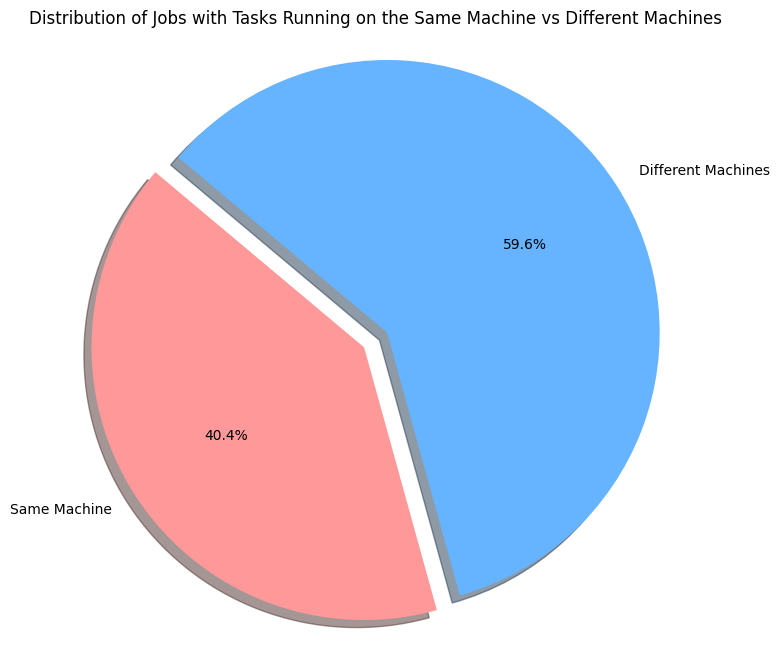

In [7]:
# Data for the pie chart
labels = ['Same Machine', 'Different Machines']
sizes = [same_machine_count, different_machine_count]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode the 1st slice (Same Machine)

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Distribution of Jobs with Tasks Running on the Same Machine vs Different Machines')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

### Conclusion

The analysis shows that out of the total jobs, 1978 jobs have tasks running on the same machine, while 2917 jobs have tasks running on different machines. This indicates that it is more common for tasks from the same job to be distributed across multiple machines rather than being confined to a single machine. This distribution could be due to the cluster's scheduling policies aimed at load balancing and resource optimization.


## Question 7

Are the tasks that request the more resources the one that consume the more resources?

### Data Processing

In [8]:
# Function to safely convert strings to floats
def safe_float(value):
    try:
        return float(value)
    except ValueError:
        return None

# Extract relevant columns from task_events with error handling
task_events_relevant_rdd = task_events_rdd.map(lambda row: ((row[2], row[3]), (safe_float(row[9]), safe_float(row[10]))))  # ((job_id, task_index), (cpu_request, memory_request))

# Extract relevant columns from task_usage with error handling
task_usage_relevant_rdd = task_usage_rdd.map(lambda row: ((row[2], row[3]), (safe_float(row[5]), safe_float(row[6]))))  # ((job_id, task_index), (cpu_rate, canonical_memory_usage))

# Filter out rows with None values
task_events_relevant_rdd = task_events_relevant_rdd.filter(lambda x: x[1][0] is not None and x[1][1] is not None)
task_usage_relevant_rdd = task_usage_relevant_rdd.filter(lambda x: x[1][0] is not None and x[1][1] is not None)

# Join the task_events and task_usage RDDs on (job_id, task_index)
joined_rdd = task_events_relevant_rdd.join(task_usage_relevant_rdd)

### Analysis

In [9]:
# Function to compare requested and consumed resources
def compare_resources(data):
    (cpu_request, memory_request), (cpu_rate, memory_usage) = data
    return (cpu_request, cpu_rate, memory_request, memory_usage)

# Apply the function to the joined RDD
resources_comparison_rdd = joined_rdd.map(lambda x: compare_resources(x[1]))

# Collect the results
resources_comparison = resources_comparison_rdd.collect()

# Calculate correlation using numpy
cpu_requests = np.array([x[0] for x in resources_comparison])
cpu_rates = np.array([x[1] for x in resources_comparison])
memory_requests = np.array([x[2] for x in resources_comparison])
memory_usages = np.array([x[3] for x in resources_comparison])

cpu_correlation = np.corrcoef(cpu_requests, cpu_rates)[0, 1]
memory_correlation = np.corrcoef(memory_requests, memory_usages)[0, 1]

print(f"Correlation between CPU request and CPU rate: {cpu_correlation}")
print(f"Correlation between memory request and memory usage: {memory_correlation}")

Correlation between CPU request and CPU rate: 0.32138752825216504
Correlation between memory request and memory usage: 0.6252361697584518


### Visualization

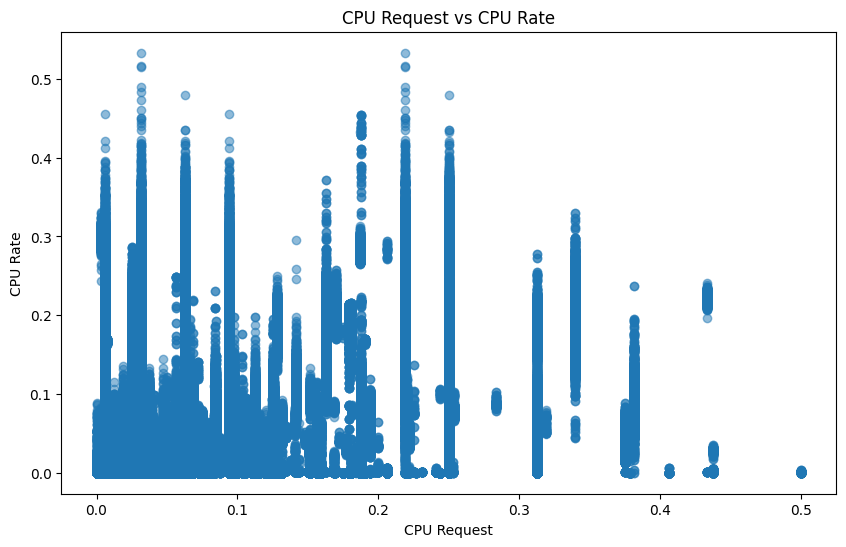

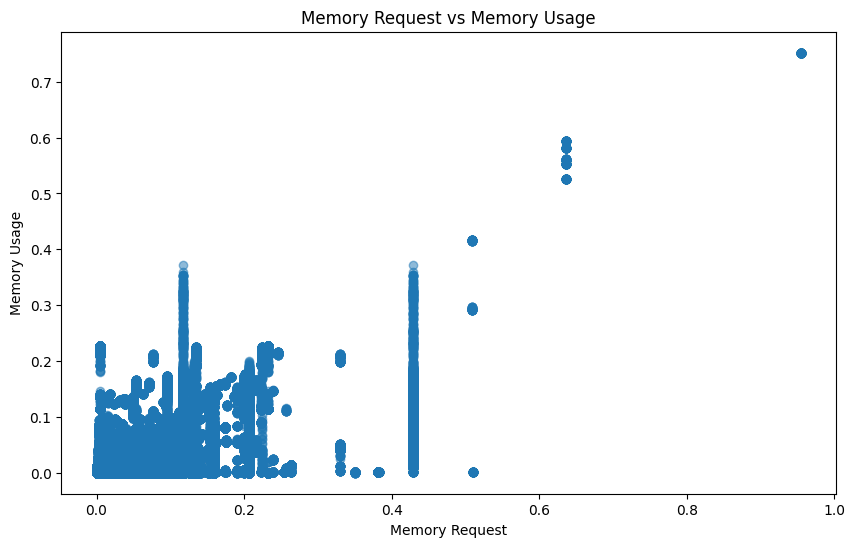

In [10]:
# Scatter plot for CPU request vs CPU rate
plt.figure(figsize=(10, 6))
plt.scatter(cpu_requests, cpu_rates, alpha=0.5)
plt.title('CPU Request vs CPU Rate')
plt.xlabel('CPU Request')
plt.ylabel('CPU Rate')
plt.show()

# Scatter plot for Memory request vs Memory usage
plt.figure(figsize=(10, 6))
plt.scatter(memory_requests, memory_usages, alpha=0.5)
plt.title('Memory Request vs Memory Usage')
plt.xlabel('Memory Request')
plt.ylabel('Memory Usage')
plt.show()

### Conclusion

These results indicate that tasks that request more CPU and memory resources don't necessarly consume more, respectively. The strength of the correlations suggests that the relationship is not perfect and that other factors may influence resource consumption. Memory requests tend to be more accurate predictors of actual usage compared to CPU requests.



## Question 8

Can we observe correlations between peaks of high resource consumption on some machines and task eviction events?

### Data Processing

In [11]:
# Extract relevant columns from task_usage
task_usage_relevant_rdd = task_usage_rdd.map(lambda row: (row[4], (safe_float(row[5]), safe_float(row[6]))))  # (machine_id, (cpu_rate, canonical_memory_usage))

# Extract relevant columns from task_events
task_events_relevant_rdd = task_events_rdd.map(lambda row: (row[4], (row[0], row[5])))  # (machine_id, (timestamp, event_type))

# Filter for eviction events (event_type == 2)
eviction_events_rdd = task_events_relevant_rdd.filter(lambda x: x[1][1] == '2').map(lambda x: (x[0], x[1][0]))  # (machine_id, timestamp)

### Analysis

In [12]:
# Function to identify peaks in resource consumption
def identify_peaks(data):
    machine_id, usage = data
    cpu_rates = [x[0] for x in usage]
    memory_usages = [x[1] for x in usage]
    peak_cpu = max(cpu_rates)
    peak_memory = max(memory_usages)
    return (machine_id, (peak_cpu, peak_memory))

# Group by machine_id and identify peaks
peaks_rdd = task_usage_relevant_rdd.groupByKey().map(identify_peaks)

# Group eviction events by machine_id
grouped_eviction_events_rdd = eviction_events_rdd.groupByKey()

# Join peaks with grouped eviction events on machine_id
peaks_evictions_rdd = peaks_rdd.join(grouped_eviction_events_rdd)

# Function to correlate peaks with eviction events
def correlate_peaks_evictions(data):
    machine_id, (peaks, evictions) = data
    peak_cpu, peak_memory = peaks
    eviction_count = len(evictions)
    return (machine_id, peak_cpu, peak_memory, eviction_count)

# Apply the function to the joined RDD
correlation_rdd = peaks_evictions_rdd.map(correlate_peaks_evictions)

# Collect the results
correlation_results = correlation_rdd.collect()

# Analyze the correlation between peaks and evictions
peak_cpus = np.array([x[1] for x in correlation_results])
peak_memories = np.array([x[2] for x in correlation_results])
eviction_counts = np.array([x[3] for x in correlation_results])

# Calculate correlation using numpy
cpu_eviction_correlation = np.corrcoef(peak_cpus, eviction_counts)[0, 1]
memory_eviction_correlation = np.corrcoef(peak_memories, eviction_counts)[0, 1]

print(f"Correlation between peak CPU usage and eviction events: {cpu_eviction_correlation}")
print(f"Correlation between peak memory usage and eviction events: {memory_eviction_correlation}")

Correlation between peak CPU usage and eviction events: -0.06066387112968303
Correlation between peak memory usage and eviction events: -0.008290154686191016


### Visualization

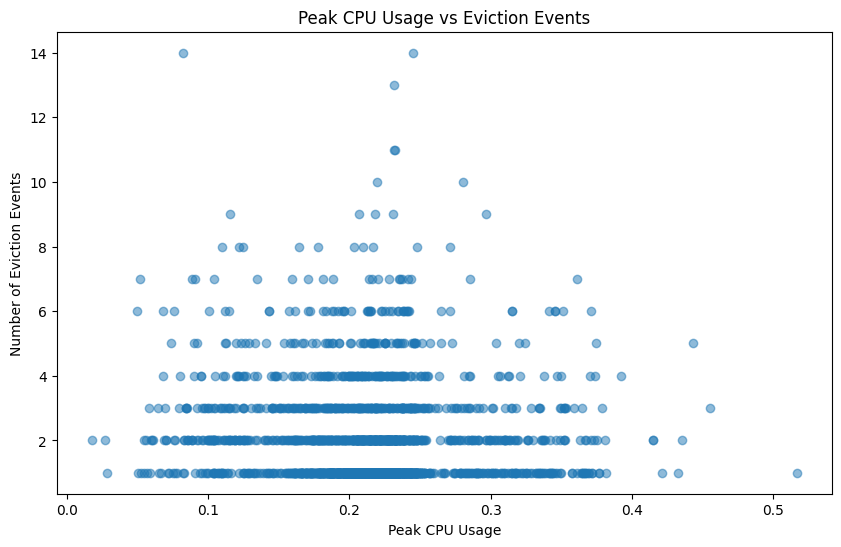

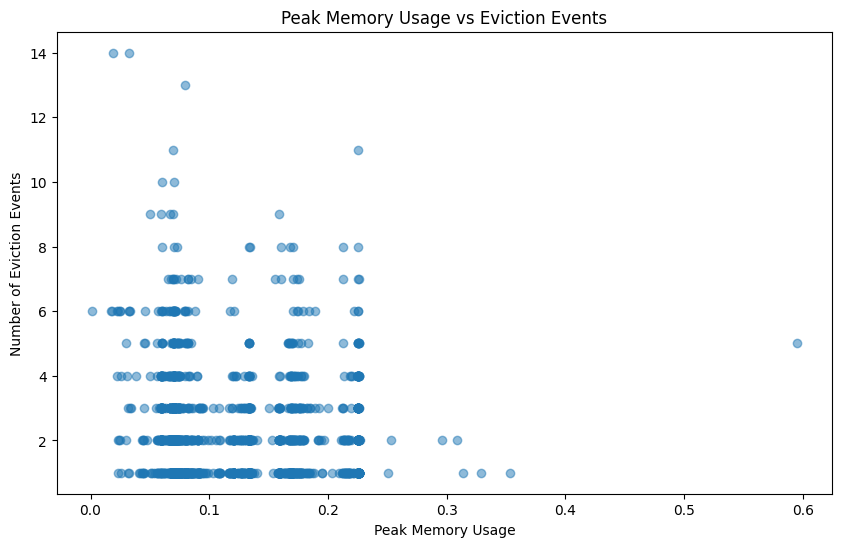

In [13]:
# Scatter plot for peak CPU usage vs eviction events
plt.figure(figsize=(10, 6))
plt.scatter(peak_cpus, eviction_counts, alpha=0.5)
plt.title('Peak CPU Usage vs Eviction Events')
plt.xlabel('Peak CPU Usage')
plt.ylabel('Number of Eviction Events')
plt.show()

# Scatter plot for peak Memory usage vs eviction events
plt.figure(figsize=(10, 6))
plt.scatter(peak_memories, eviction_counts, alpha=0.5)
plt.title('Peak Memory Usage vs Eviction Events')
plt.xlabel('Peak Memory Usage')
plt.ylabel('Number of Eviction Events')
plt.show()

### Conclusion

The analysis shows that there is a very weak negative correlation between peak CPU usage and eviction events (approximately -0.06), and an even weaker negative correlation between peak memory usage and eviction events (approximately -0.008).

These results suggest that there is no significant relationship between high resource consumption (both CPU and memory) and the occurrence of task eviction events. This indicates that peaks in resource usage are not strong predictors of task evictions in the Google cluster data.

## Question 9: Bonus question 2

Are there specific times of the day when resource consumption peaks?

### Analysis

In [14]:
# Extract hour and resources
def get_hour_and_resources(row):
    try:
        hour = int(float(row[0])) % 86400 // 3600  # Convert to hour (0-23)
        cpu = safe_float(row[5])
        memory = safe_float(row[6])
        if cpu is not None and memory is not None:
            return (hour, (cpu, memory, 1))
        return None
    except:
        return None

hourly_data = task_usage_rdd.map(get_hour_and_resources).filter(lambda x: x is not None)

# Aggregate by hour
def sum_resources(a, b):
    return (a[0] + b[0], a[1] + b[1], a[2] + b[2])

hourly_averages = hourly_data.reduceByKey(sum_resources).mapValues(lambda x: (x[0]/x[2], x[1]/x[2])).sortByKey()

# Collect results
results = hourly_averages.collect()

### Visualization

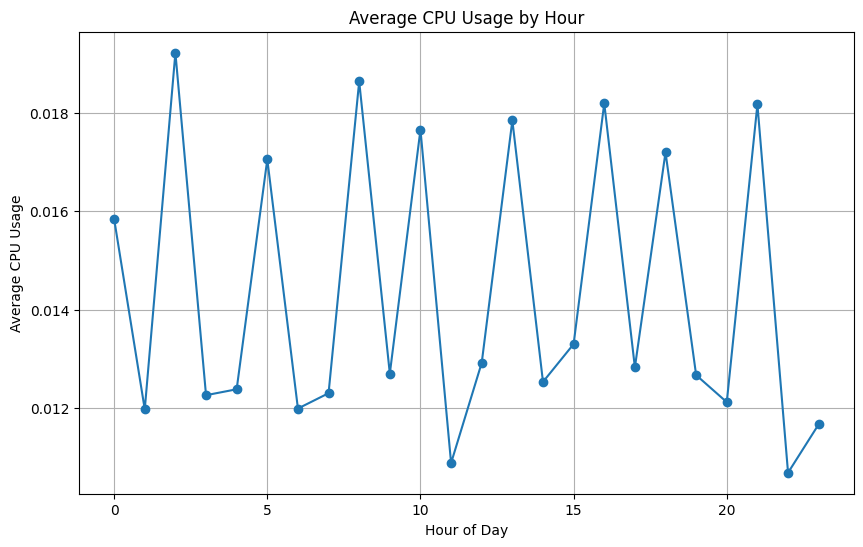

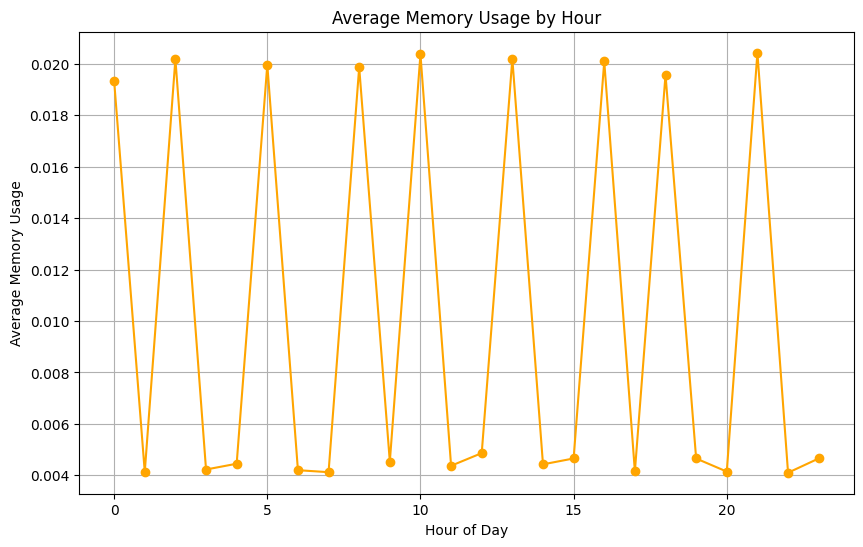

In [15]:
# Prepare plotting data
hours = [x[0] for x in results]
avg_cpu = [x[1][0] for x in results]
avg_memory = [x[1][1] for x in results]

# CPU Usage
plt.figure(figsize=(10, 6))
plt.plot(hours, avg_cpu, marker='o')
plt.title('Average CPU Usage by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average CPU Usage')
plt.grid(True)
plt.show()

# Memory Usage
plt.figure(figsize=(10, 6))
plt.plot(hours, avg_memory, marker='o', color='orange')
plt.title('Average Memory Usage by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Memory Usage')
plt.grid(True)
plt.show()

### Conclusion

The analysis shows that there is no specific time of the day when resource consumption peaks in a remarkable manner compared to other times. Instead, the resource consumption fluctuates throughout the day, with both CPU and memory usage going up and down. This indicates that the resource usage is relatively balanced over the 24-hour period, without significant peaks at any particular period.